/home/noa/Data/radovi/gaia-sdss-spectra/venv/lib/python3.11/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


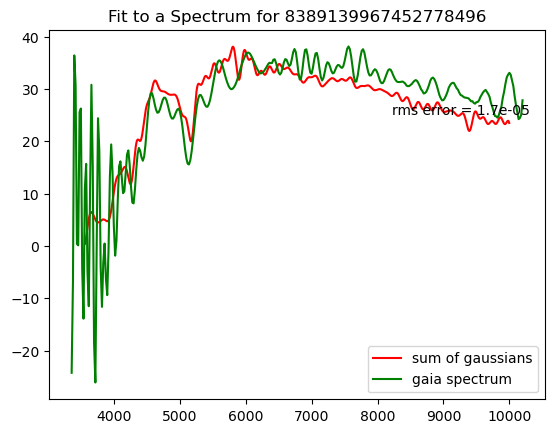

/home/noa/Data/radovi/gaia-sdss-spectra/venv/lib/python3.11/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


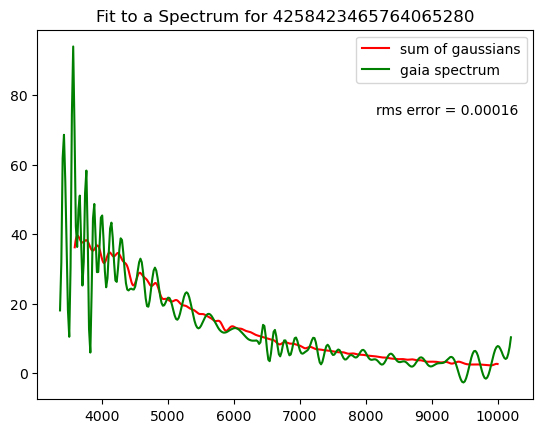

In [14]:
import gaiaxpy as gxp
import matplotlib.pyplot as plt
import sdss

from astroML.sum_of_norms import sum_of_norms, norm
from astroquery.sdss import SDSS as aq_sdss


sdss_object_ids = [
    '3722249363855089664',
    '367197615982405632',
    '8389139967452778496',
    '4257205206863712256',
    '4244796668237451264',
    '4253860491988701184',
    '4536514151959105536',
    '4258423465764065280',
    '382896161666656256',
    '382895057138640896',
]

# source_id column in gaia tables
gaia_object_ids = [
    '3697673684568672128',
    '3796709621755671936',
    '3083075344961618432',
    '3838985152354159616',
    '3830530629490514688',
    '3695424706549076096',
    '3649931446581878016',
    '3827682344618411776',
    '3685862906757553664',
    '3685862906757553664',
]

# gaia_spectra_calib, sampling = gxp.calibrate(gaia_object_ids)

#

for object_id, gaia_object_id in zip(sdss_object_ids, gaia_object_ids):
    try:
        gaia_spectrum, sampling = gxp.calibrate([gaia_object_id])

        gaia_spectrum = gaia_spectrum['flux'][0] * 1e19  # kms to cgs ???????
        sampling = sampling * 10  # nm to Å
    except ValueError as e:
        continue
    
    sp = sdss.SpecObj(object_id)
    data = aq_sdss.get_spectra(plate=sp.plate, mjd=sp.mjd, fiberID=sp.fiberID)
    if not (data and len(data) > 0 and len(data[0]) > 1 and hasattr(data[0][1], 'data')):
        print("Doesn't exist")
        continue
        

    spec_data = data[0][1].data

    x = wavelength = 10 ** spec_data['loglam']  # Convert logarithmic wavelength to linear
    y = flux = spec_data['flux']

    # truncate the spectrum
    mask = (x >= 2000) & (x < 10000)
    x = x[mask]
    y = y[mask]

    w_best, rms, locs, widths = sum_of_norms(x, y, 100,
                                             spacing='linear',
                                             full_output=True)

    norms = w_best * norm(x[:, None], locs, widths)

    # plot the results

    #Original spectrum
    #plt.figure()
    #plt.plot(x, y, '-k', label='input spectrum')
    #ylim = plt.ylim()

    #Individual gaussians
    #plt.plot(x, norms, ls='-', c='#FFAAAA')

    #Sum of gaussians
    plt.plot(x, norms.sum(1), '-r', label='sum of gaussians')
    plt.plot(sampling, gaia_spectrum, '-g', label='gaia spectrum')
#     plt.ylim(-0.1 * ylim[1], ylim[1])   # ylim is undefined 

    plt.legend(loc=0)

    plt.text(0.97, 0.8,"rms error = %.2g" % rms,ha='right', va='top', transform=plt.gca().transAxes)
    plt.title("Fit to a Spectrum for %s" % object_id)

    plt.show()
    